https://www.bgc-jena.mpg.de/wetter/

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest

# visualization
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 6.0)

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("mpi_roof\mpi_roof.csv",encoding= 'unicode_escape')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31931 entries, 0 to 31930
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             31931 non-null  object 
 1   p (mbar)              31931 non-null  float64
 2   T (degC)              31931 non-null  float64
 3   Tpot (K)              31931 non-null  float64
 4   Tdew (degC)           31931 non-null  float64
 5   rh (%)                31931 non-null  float64
 6   VPmax (mbar)          31931 non-null  float64
 7   VPact (mbar)          31931 non-null  float64
 8   VPdef (mbar)          31931 non-null  float64
 9   sh (g/kg)             31931 non-null  float64
 10  H2OC (mmol/mol)       31931 non-null  float64
 11  rho (g/m**3)          31931 non-null  float64
 12  wv (m/s)              31931 non-null  float64
 13  max. wv (m/s)         31931 non-null  float64
 14  wd (deg)              31931 non-null  float64
 15  rain (mm)          

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,...,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,990.646484,10.966426,284.885015,6.840672,79.511083,15.146275,10.647325,4.498847,6.718122,10.750479,...,2.057666,3.385259,172.644516,0.009580,31.957032,106.328058,208.339513,250.871895,19.939707,424.905399
std,8.268963,8.751587,8.807894,6.027105,19.419032,8.942102,4.077635,6.807391,2.587192,4.123436,...,1.448510,2.203478,83.729286,0.167079,123.946813,193.646628,376.554554,479.030428,8.154881,303.832296
min,955.430000,-13.390000,259.340000,-14.190000,14.230000,2.170000,2.030000,0.000000,1.260000,2.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.410000,-9999.000000
25%,985.930000,4.610000,278.640000,2.890000,68.700000,8.490000,7.520000,0.290000,4.730000,7.590000,...,0.990000,1.750000,119.500000,0.000000,0.000000,0.000000,0.000000,0.000000,13.630000,420.100000
50%,991.160000,11.070000,285.160000,7.330000,84.200000,13.200000,10.250000,1.820000,6.470000,10.360000,...,1.710000,2.850000,195.100000,0.000000,0.000000,0.000000,0.000000,0.000000,19.150000,430.100000
75%,995.540000,17.025000,290.870000,11.465000,96.200000,19.435000,13.560000,5.580000,8.550000,13.680000,...,2.740000,4.490000,224.950000,0.000000,0.000000,121.430000,241.275000,288.995000,25.195000,444.300000
max,1014.630000,37.950000,312.210000,19.720000,100.000000,66.130000,23.010000,56.720000,14.670000,23.380000,...,12.810000,17.820000,360.000000,19.200000,600.000000,1044.180000,2026.210000,2485.400000,45.800000,530.200000


In [3]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
1,01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
2,01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
3,01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
4,01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [4]:
data["Date"] = pd.to_datetime(data["Date Time"])

# data["Date"] = data["Date Time"].astype("datetime64[ns]")
data["Date"].shape

(31930,)

In [5]:
data.set_index("Date Time",inplace=True)
data.drop("Date",axis=1,inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,23.38,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,23.38,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,23.32,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,23.03,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,22.92,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


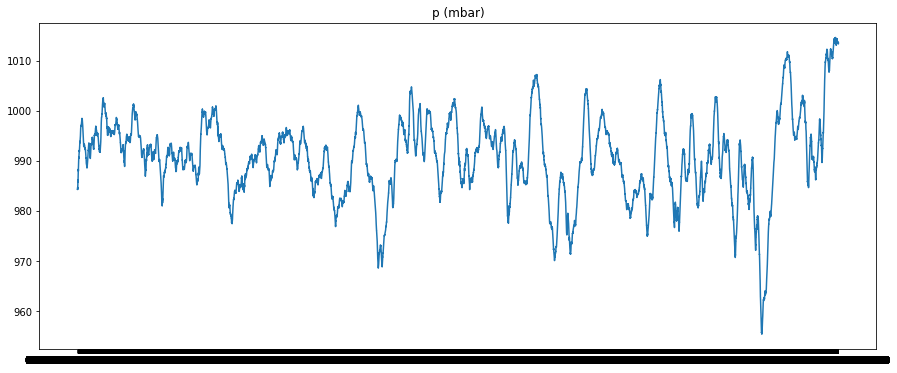

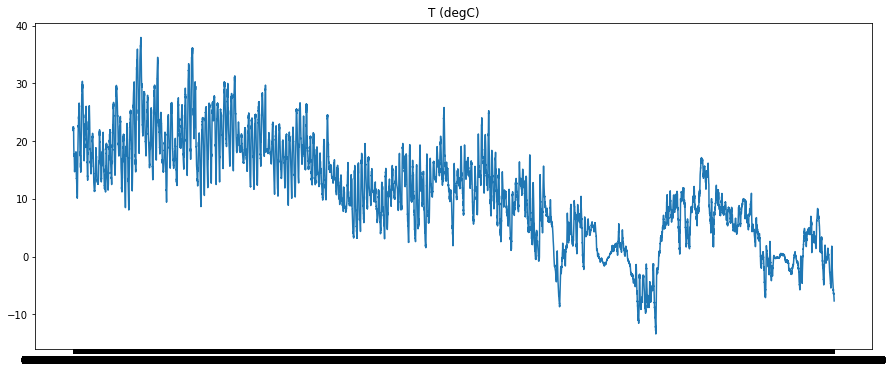

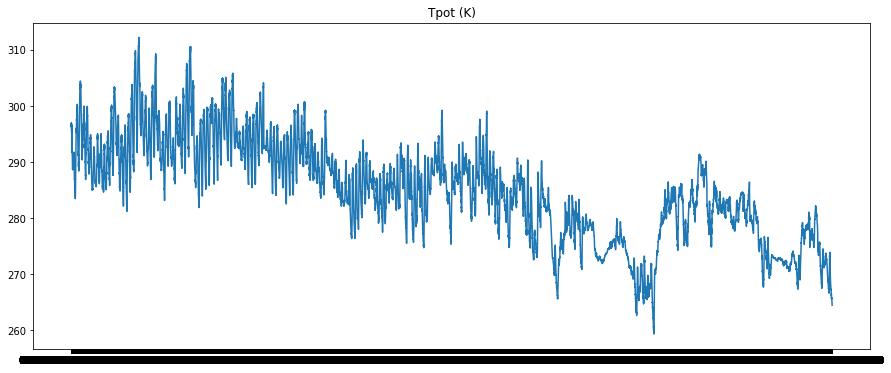

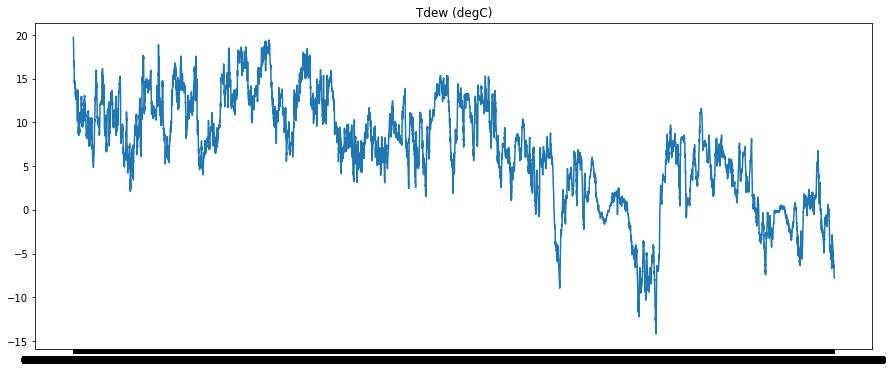

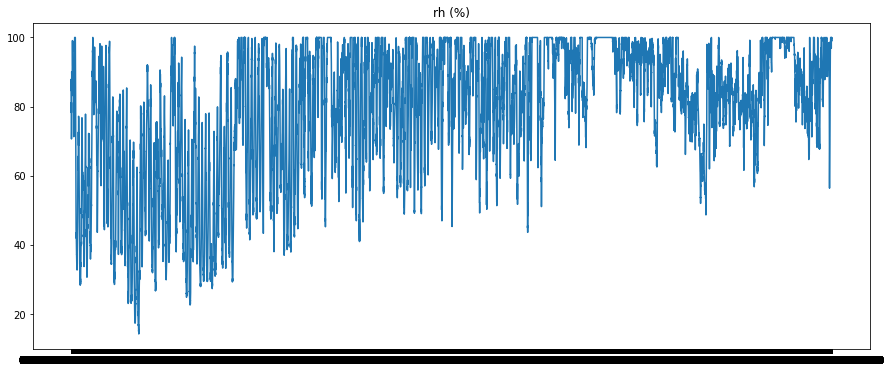

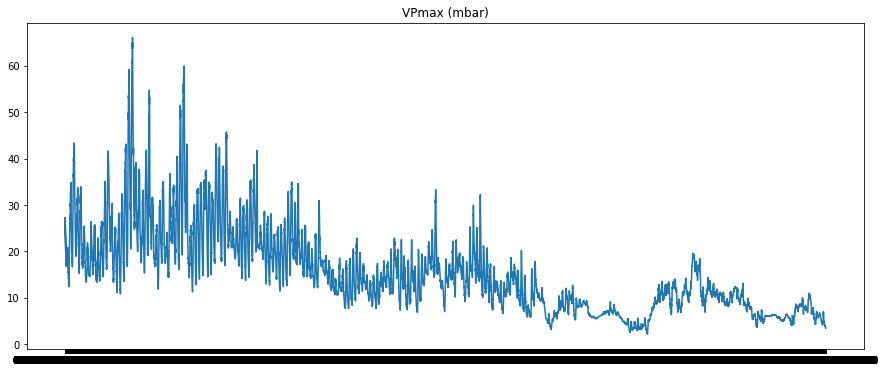

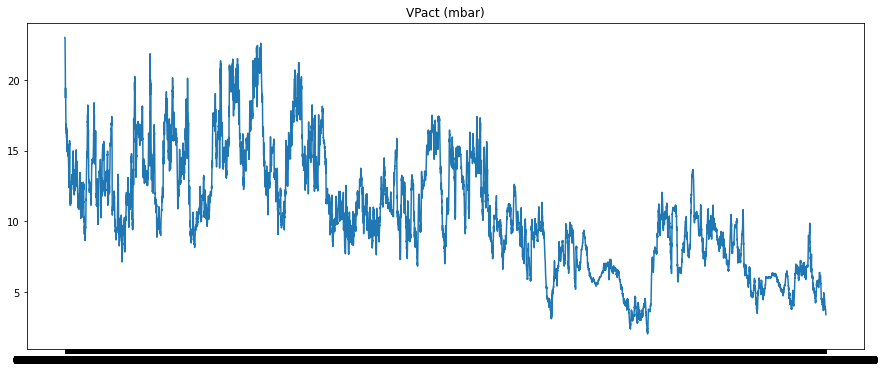

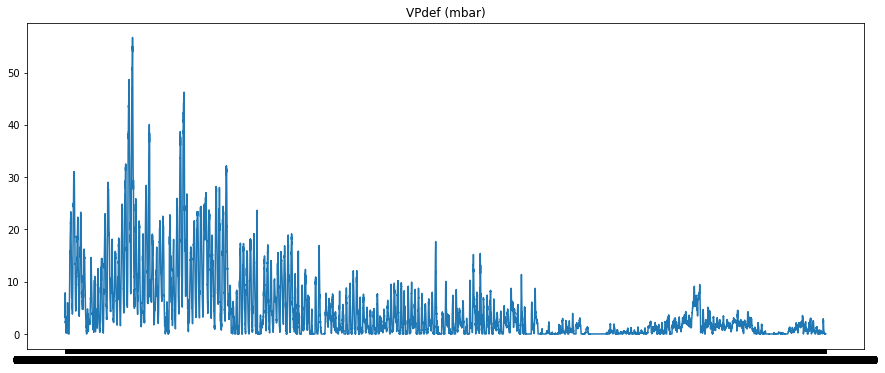

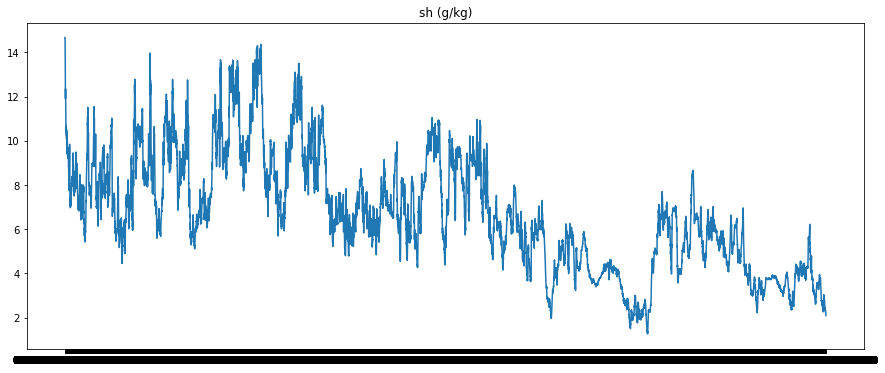

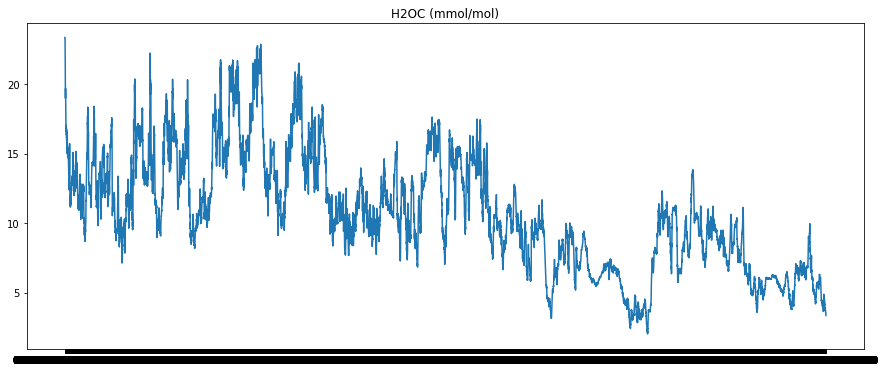

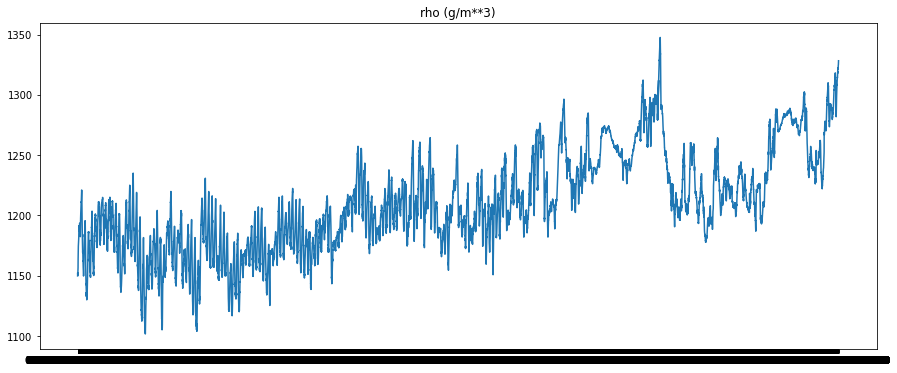

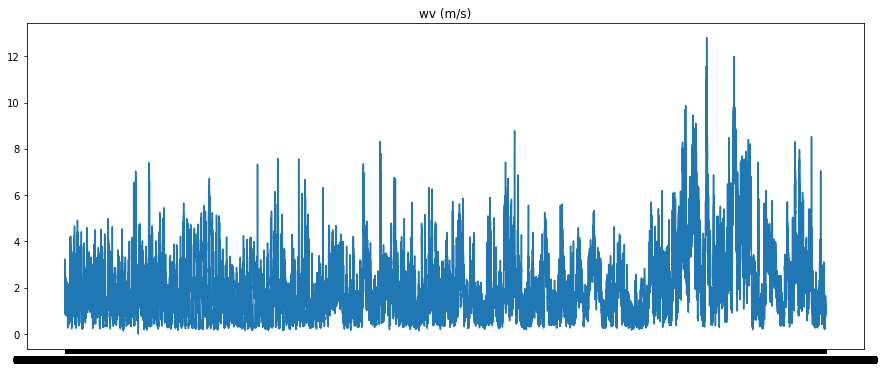

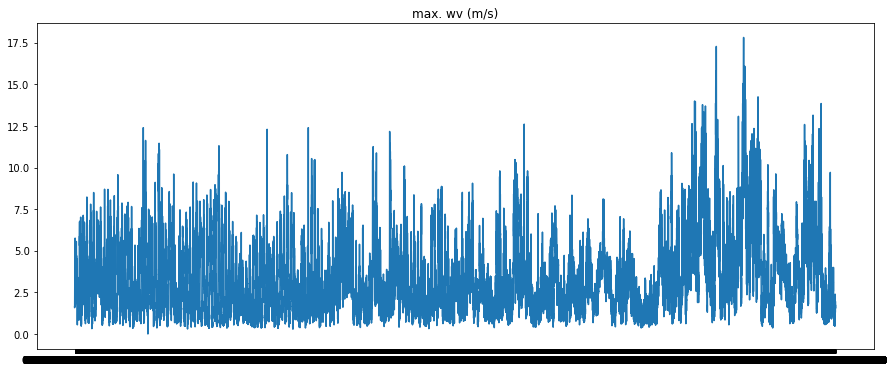

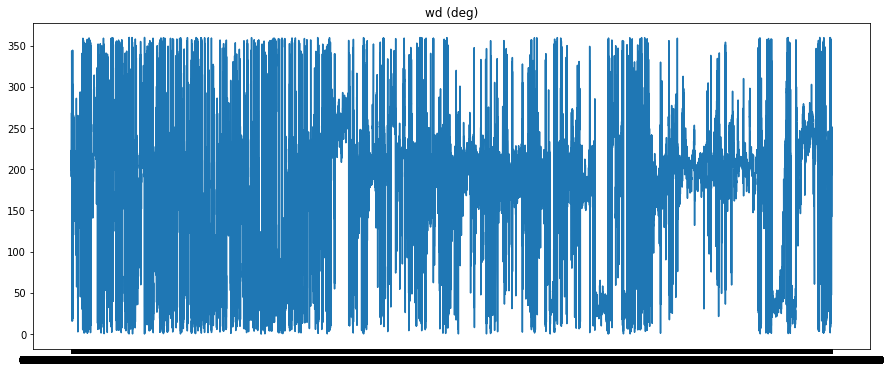

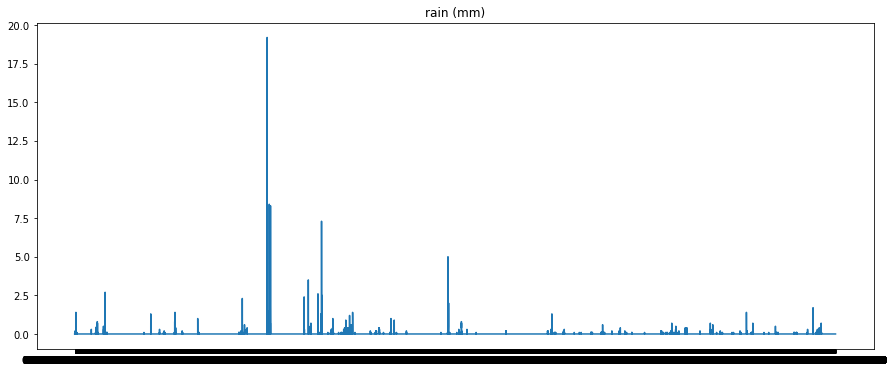

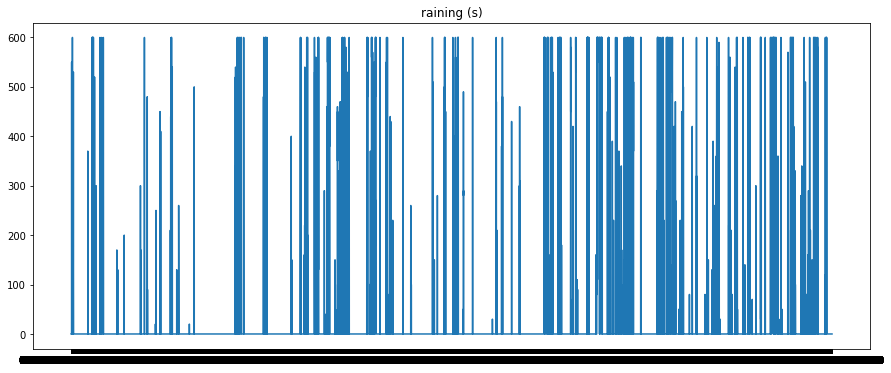

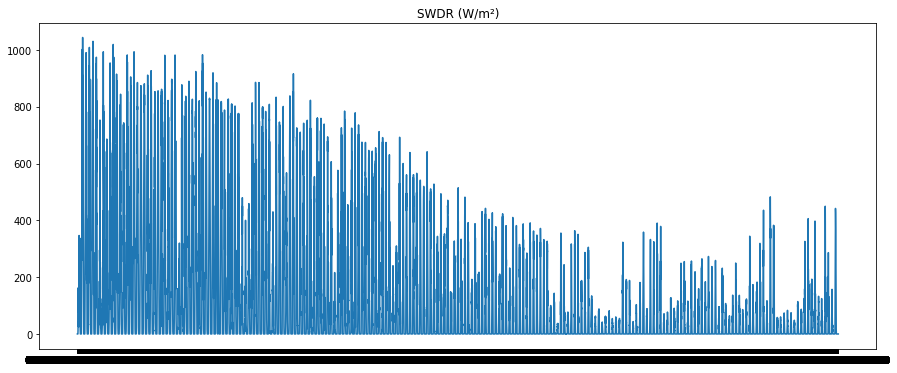

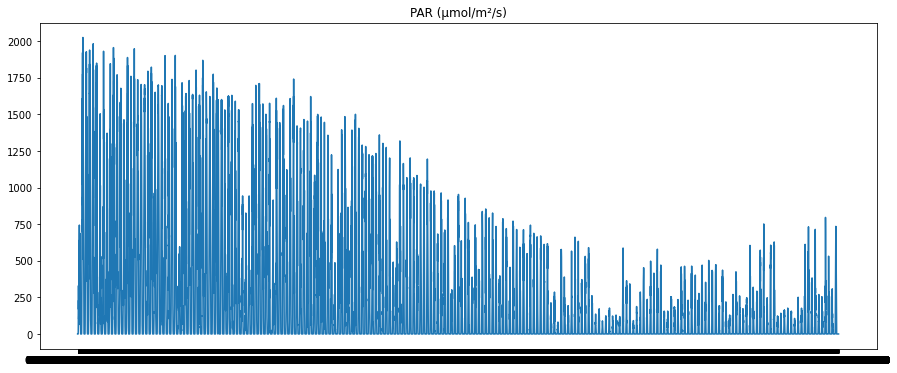

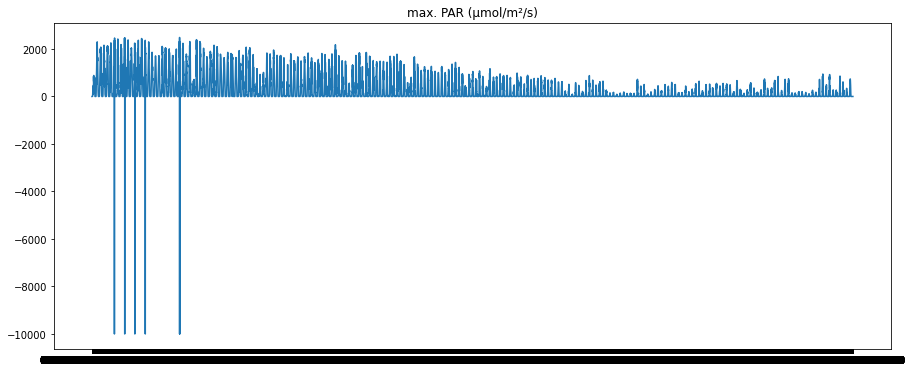

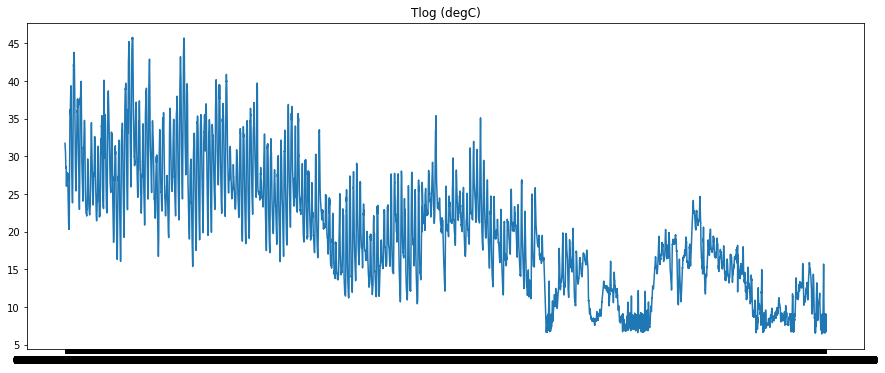

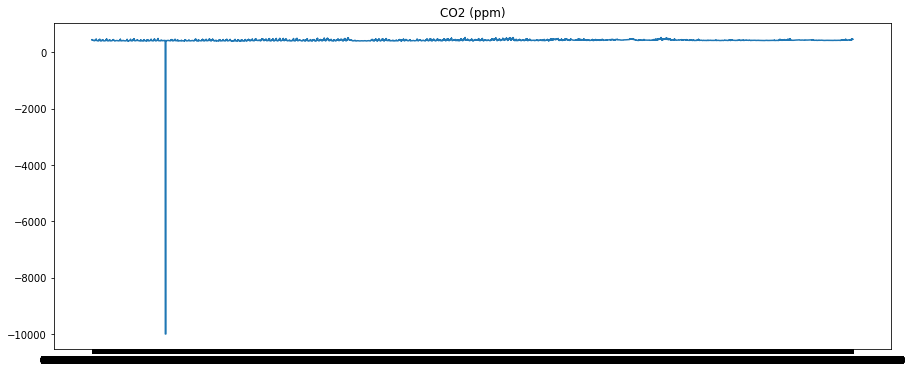

In [6]:
for i in range(data.shape[1]):
    plt.figure(figsize=(15,6))
    plt.plot(data.iloc[:,i])
    plt.title(list(data.columns)[i])
    plt.show()